In [1]:
%load_ext autoreload

In [111]:
%autoreload 2
from UniversalUnconsciousness.data_utils import get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import convert_h5_string_array
from UniversalUnconsciousness.plot_utils import get_session_plot_info, load_font, plot_sensory_responses_etdc
from UniversalUnconsciousness.sensory_responses import cosine_sim_corrmat, get_responses_etdc, get_sensory_responses_leverOddball, get_sensory_responses_propofol
from hydra import initialize, compose
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
verbose = False
agent_data = {}

for data_class, agent in tqdm(anesthetic_agent_list):
    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info

  0%|          | 0/3 [00:00<?, ?it/s]

In [158]:
doses_to_process = ['high']
for data_class, agent in tqdm(anesthetic_agent_list):
    if agent == 'propofol':
        continue
        leadup = 250
        response = 550
        trial_type = 'toneOnly'
    else:
        leadup = 250
        # response = 270
        # response = 550
        # trial_type = 'lvr_tone'
        response = 1200
        trial_type = 'oddball'
    

    session_lists = agent_data[(data_class, agent)]['session_lists']
    noise_filter_info = agent_data[(data_class, agent)]['noise_filter_info']
    cfg.params.data_class = data_class
    iterator = tqdm(total=sum([len(session_lists[monkey][dose]) for monkey in session_lists.keys() for dose in doses_to_process]))
    sensory_responses = {}
    for monkey in session_lists.keys():
        sensory_responses[monkey] = {}
        # for dose in session_lists[monkey]:
        for dose in doses_to_process:
            sensory_responses[monkey][dose] = {}
            for session in session_lists[monkey][dose]:
                if 'propofol' in cfg.params.data_class:
                    responses, dt = get_sensory_responses_propofol(cfg, session, noise_filter_info, trial_type, leadup, response)
                    sensory_responses[monkey][dose][session] = responses
                else:
                    tone_lfps, dt = get_sensory_responses_leverOddball(cfg, session, noise_filter_info, trial_type, leadup, response)
                    sensory_responses[monkey][dose][session] = tone_lfps
                iterator.update(1)
    iterator.close()
    agent_data[(data_class, agent)]['sensory_responses'] = sensory_responses
    agent_data[(data_class, agent)]['dt'] = dt
    agent_data[(data_class, agent)]['leadup'] = leadup
    agent_data[(data_class, agent)]['response'] = response


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [164]:
dose = 'high'

data_class, agent = ('anesthesiaLvrOdd', 'ketamine')
# monkey = 'SPOCK'
# session = 'SPOCK_Ketamine_20210712'
monkey = 'PEDRI'
session = 'PEDRI_Ketamine_20220106'
# awake_section = 'awake lever2'
# anesthesia_section = 'early unconscious'
awake_section = 'awake oddball'
anesthesia_section = 'unconscious oddball'

# data_class, agent = ('propofolPuffTone', 'propofol')
# monkey = 'Mary'
# # session = 'Mary-Anesthesia-20160818-02'
# session = 'Mary-Anesthesia-20160809-01'
# section = 'awake'

# data_class, agent = ('anesthesiaLvrOdd', 'ketamine')
# # monkey = 'SPOCK'
# # session = 'SPOCK_Ketamine_20210712'
# monkey = 'PEDRI'
# session = 'PEDRI_Ketamine_20220106'
# awake_section = 'awake lever2'
# anesthesia_section = 'early unconscious'


In [165]:
responses_vecs_awake = agent_data[(data_class, agent)]['sensory_responses'][monkey][dose][session][awake_section]
corrmat_awake = cosine_sim_corrmat(responses_vecs_awake)
responses_vecs_anesthesia = agent_data[(data_class, agent)]['sensory_responses'][monkey][dose][session][anesthesia_section]
corrmat_anesthesia = cosine_sim_corrmat(responses_vecs_anesthesia)

/tmp/ipykernel_336812/1805268258.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for colorbar


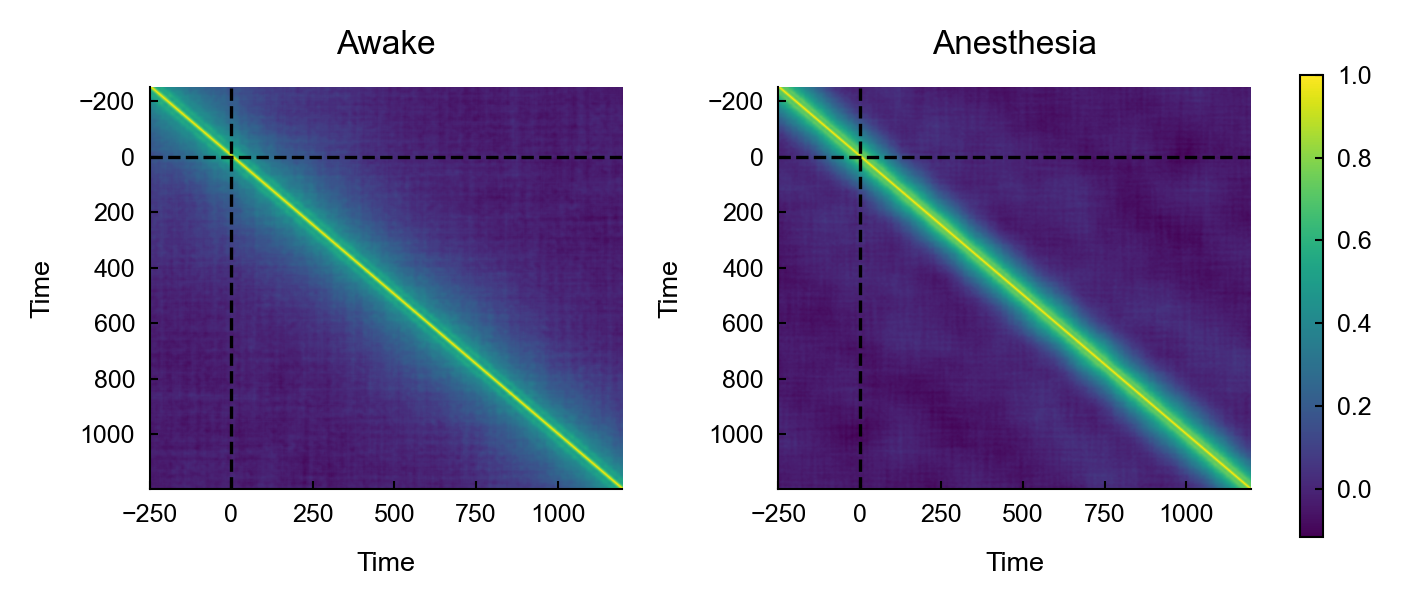

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2))

time_vals = np.arange(corrmat_awake.shape[-1]) - leadup

mean_awake = corrmat_awake.mean(axis=0)
mean_anesthesia = corrmat_anesthesia.mean(axis=0)

vmin = min(mean_awake.min(), mean_anesthesia.min())
vmax = max(mean_awake.max(), mean_anesthesia.max())

# Plot awake response_vecs
im1 = axes[0].imshow(mean_awake, vmin=vmin, vmax=vmax, extent=[time_vals[0], time_vals[-1], time_vals[-1], time_vals[0]], aspect='auto')
axes[0].set_title('Awake')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Time')
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.8)
axes[0].axvline(0, color='k', linestyle='--', linewidth=0.8)

# Plot anesthesia response_vecs
im2 = axes[1].imshow(mean_anesthesia, vmin=vmin, vmax=vmax, extent=[time_vals[0], time_vals[-1], time_vals[-1], time_vals[0]], aspect='auto')
axes[1].set_title('Anesthesia')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Time')
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.8)
axes[1].axvline(0, color='k', linestyle='--', linewidth=0.8)

# Ensure both plots have the same color scale
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for colorbar
plt.show()

/tmp/ipykernel_336812/4179750255.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for colorbar


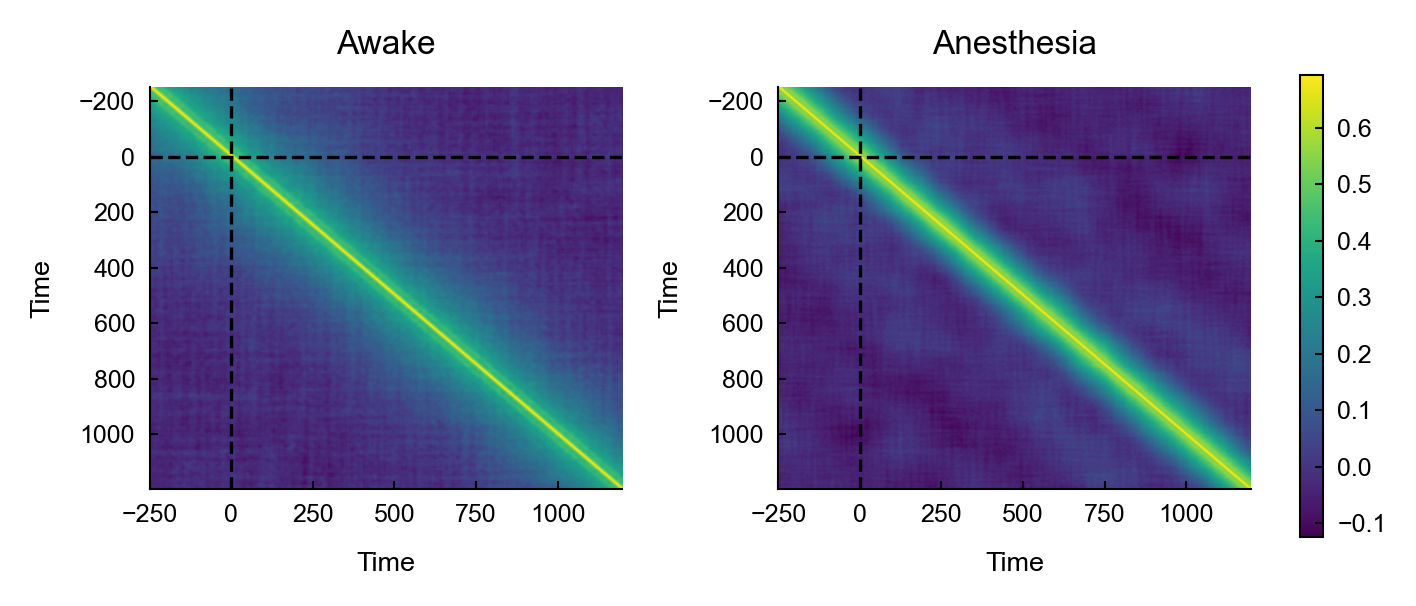

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2))

time_vals = np.arange(corrmat_awake.shape[-1]) - leadup

mean_awake = np.log1p(corrmat_awake.mean(axis=0))
mean_anesthesia = np.log1p(corrmat_anesthesia.mean(axis=0))

vmin = min(mean_awake.min(), mean_anesthesia.min())
vmax = max(mean_awake.max(), mean_anesthesia.max())

# Plot awake response_vecs on a log scale
im1 = axes[0].imshow(mean_awake, vmin=vmin, vmax=vmax, extent=[time_vals[0], time_vals[-1], time_vals[-1], time_vals[0]], aspect='auto')
axes[0].set_title('Awake')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Time')
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.8)
axes[0].axvline(0, color='k', linestyle='--', linewidth=0.8)

# Plot anesthesia response_vecs on a log scale
im2 = axes[1].imshow(mean_anesthesia, vmin=vmin, vmax=vmax, extent=[time_vals[0], time_vals[-1], time_vals[-1], time_vals[0]], aspect='auto')
axes[1].set_title('Anesthesia')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Time')
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.8)
axes[1].axvline(0, color='k', linestyle='--', linewidth=0.8)

# Ensure both plots have the same color scale
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for colorbar
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

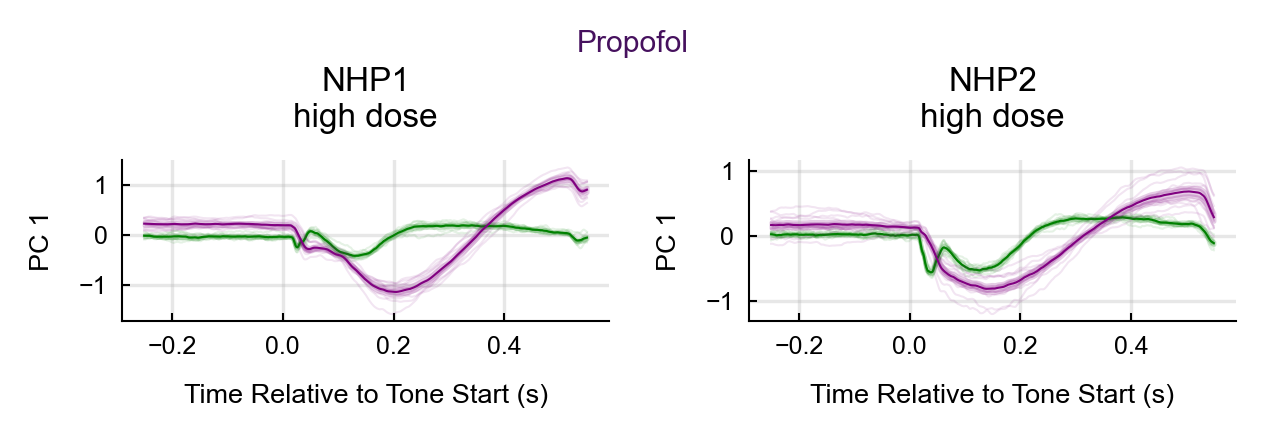

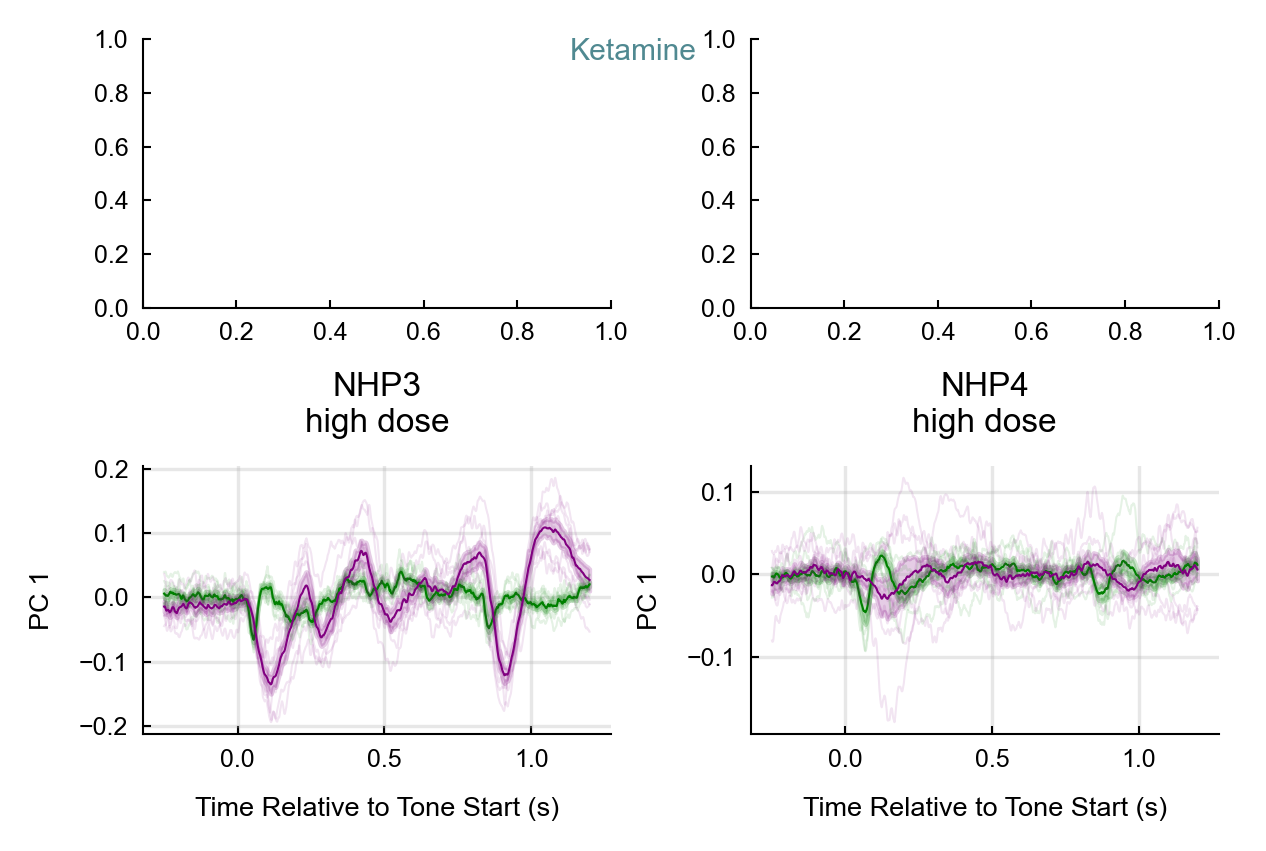

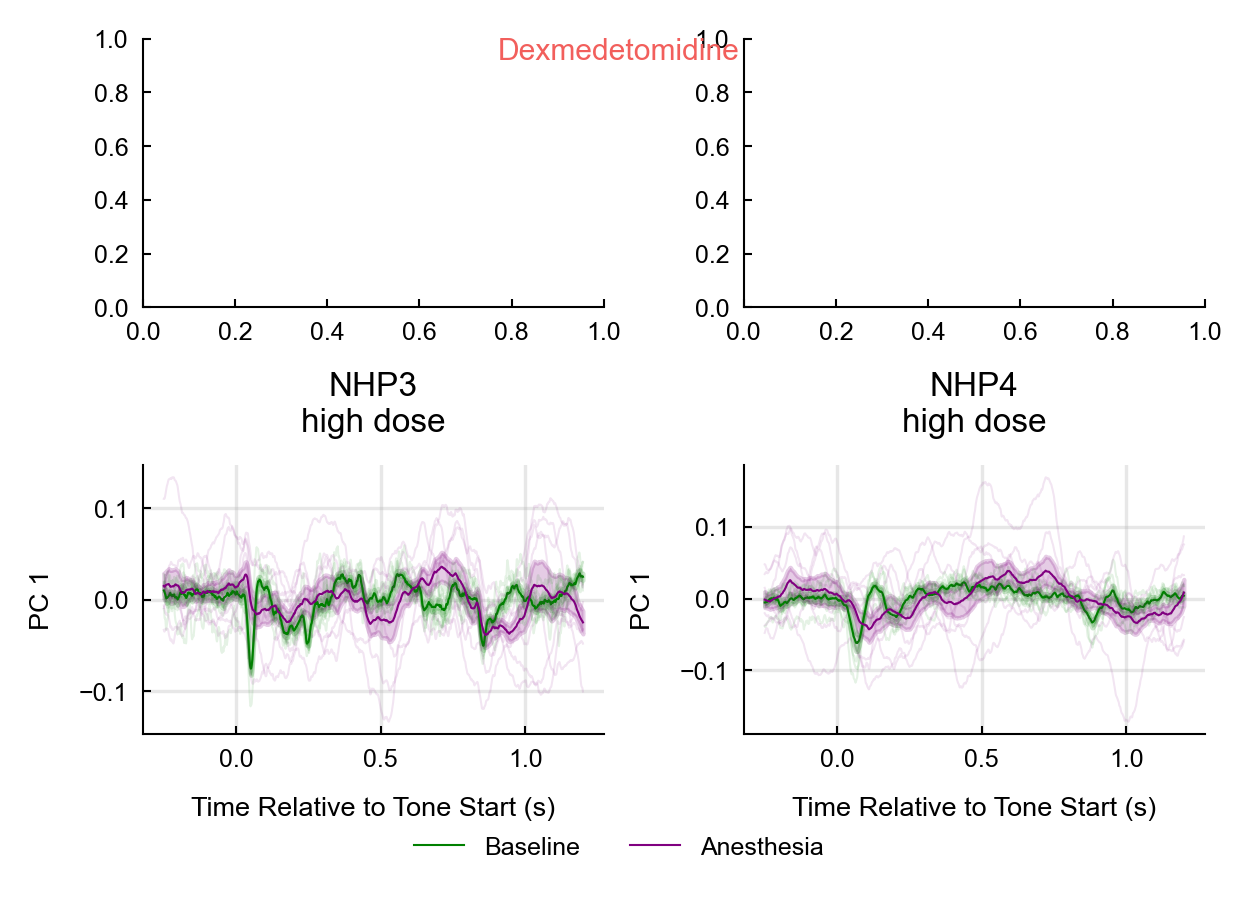

In [168]:
n_delays = 1
delay_interval = 1
for data_class, agent in tqdm(anesthetic_agent_list):
    sensory_responses = agent_data[(data_class, agent)]['sensory_responses']
    leadup = agent_data[(data_class, agent)]['leadup']
    response = agent_data[(data_class, agent)]['response']
    dt = agent_data[(data_class, agent)]['dt']
    plot_sensory_responses_etdc(
        agent,
        curve_colors,
        sensory_responses, 
        leadup, 
        response, 
        dt=dt, 
        n_delays=n_delays, 
        delay_interval=delay_interval,
        plot_legend=True if 'dex' in agent else False,
        # save_path=os.path.join(img_save_dir, f'{agent}_sensory_responses_leverresponsetime_{response}.png')
    )